In [27]:
import numpy as np, yfinance as yf
import datetime, numpy as np, pandas as pd
import QuantLib as ql 
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

In [28]:
df = yf.download("AAPL",start='2019-01-01',end='2021-12-31')
df.dropna(inplace=True)


[*********************100%***********************]  1 of 1 completed


In [29]:
last_price = np.round(df['Close'].values[-1],2)
put_strike=np.round(last_price,0)
call_strike = np.round(last_price*1.1,0)
print(f"Current Price is {last_price}")
print(f"ATM Put Strike: {put_strike}")
print(f"10% OTM Call Strikes: {call_strike}")

Current Price is 145.86
ATM Put Strike: 146.0
10% OTM Call Strikes: 160.0


In [30]:
def american_pricer(spot_price,strike_price, price_date, expiry_date, 
                    volatility=.20,dividend_rate=0.0,opt_type="Call",risk_free_rate=.001):
    if opt_type.lower() == "call":
        option_type = ql.Option.Call
    else:
        option_type = ql.Option.Put
    maturity_date = ql.Date(int(expiry_date.split("-")[-1]), int(expiry_date.split("-")[1]), int(expiry_date.split("-")[0]))
    calculation_date = ql.Date(int(price_date.split("-")[-1]), int(price_date.split("-")[1]), int(price_date.split("-")[0]))
    day_count = ql.Actual365Fixed()
    calendar = ql.UnitedStates()
    payoff = ql.PlainVanillaPayoff(option_type, strike_price)
    settlement = calculation_date
    am_exercise = ql.AmericanExercise(settlement, maturity_date)
    american_option = ql.VanillaOption(payoff, am_exercise)
    spot_handle = ql.QuoteHandle(
        ql.SimpleQuote(spot_price)
    )
    flat_ts = ql.YieldTermStructureHandle(
        ql.FlatForward(calculation_date, risk_free_rate, day_count)
    )
    dividend_yield = ql.YieldTermStructureHandle(
        ql.FlatForward(calculation_date, dividend_rate, day_count)
    )
    flat_vol_ts = ql.BlackVolTermStructureHandle(
        ql.BlackConstantVol(calculation_date, calendar, volatility, day_count)
    )
    bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                               dividend_yield, 
                                               flat_ts, 
                                               flat_vol_ts)
    steps = 2000
    binomial_engine = ql.BinomialVanillaEngine(bsm_process, "crr", steps)
    american_option.setPricingEngine(binomial_engine)
    return (np.round(american_option.NPV(),2))

In [31]:
spot_price = last_price
volatility = 0.20
dividend_rate =  0.06
risk_free_rate = 0.001
price_date = "2021-07-30"
expiry_date = "2021-08-30"
call_price =  american_pricer(spot_price, strike_price=call_strike, price_date=price_date, dividend_rate=dividend_rate,
                                       expiry_date=expiry_date, risk_free_rate=risk_free_rate, volatility=volatility)
put_price =  american_pricer(spot_price, strike_price=put_strike, price_date=price_date, dividend_rate=dividend_rate,
                                       expiry_date=expiry_date, risk_free_rate=risk_free_rate, volatility=volatility,
                                     opt_type = 'put')

In [32]:
print(f"Price of 1 lot of Put at Strike {put_strike}: {put_price}")
print(f"Price of 1 lot of Call at Strike {call_strike}: {call_price}")

Price of 1 lot of Put at Strike 146.0: 3.84
Price of 1 lot of Call at Strike 160.0: 0.17


In [33]:
sim_price = np.linspace(.0,2,50,endpoint=True)*last_price
put_payoff = np.round(np.maximum(put_strike - sim_price,0.0) - put_price,4)
call_payoff = np.round(np.maximum(sim_price-call_strike,0) - call_price,4)

In [34]:
put_size = 25
call_size = 125
stock_size = 100


In [35]:
pay_df = pd.DataFrame()
pay_df['Payoff'] = (sim_price-last_price)*stock_size + put_payoff*put_size -call_size*call_payoff
pay_df['Stock'] = sim_price
#pay_df = pay_df.set_index('stock_price')
pay_df['0'] = 0

3. What is the biggest risk to the client?


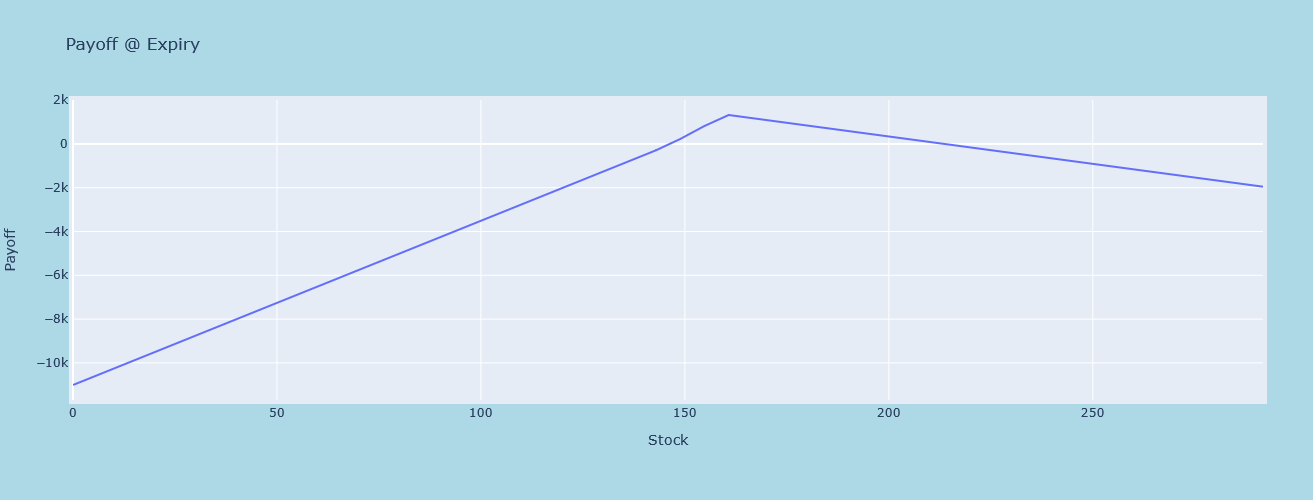

In [36]:
fig = px.line(pay_df, x="Stock", y="Payoff", title='Payoff @ Expiry')
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="LightBlue",
)

fig.show()

In [37]:
cost_of_options = call_size*call_price - put_size*put_price
print(f"Cost of Options is -- {cost_of_options}")
# max payoff will happen if at expiry the stock ends at call Strike
max_payoff = (call_strike-last_price)*stock_size + cost_of_options
print(f"Max payoff is on expiry at the Call Strike: {call_strike} of USD {max_payoff}")


Cost of Options is -- -74.75
Max payoff is on expiry at the Call Strike: 160.0 of USD 1339.2499999999986


<b>Basically Beyond OTM Strike the Client is short ~25 units of stocks and Below the ATM Put Strike the Client is exposed to 3+ delta i.e >=75 units</b>

The risk on upside can be theoretically unimited, the risk on down side can be limited to stock going to 0, we can see the range of movement in the chart above.

In [38]:
stock_delta = 1.
call_price_1 =  american_pricer(spot_price+1., strike_price=call_strike, price_date=price_date, dividend_rate=dividend_rate,
                                       expiry_date=expiry_date, risk_free_rate=risk_free_rate, volatility=volatility,
                                opt_type = 'call')
put_price_1 =  american_pricer(spot_price+1., strike_price=put_strike, price_date=price_date, dividend_rate=dividend_rate,
                                       expiry_date=expiry_date, risk_free_rate=risk_free_rate, volatility=volatility,
                                     opt_type = 'put')

call_delta = np.round(call_price_1-call_price,2)
put_delta = np.round(put_price_1-put_price,2)

In [39]:
portfolio_delta = (put_delta*put_size - call_delta*call_size + stock_delta*stock_size)
print(f"Portfolio Delta @ Inception is:{portfolio_delta}")

Portfolio Delta @ Inception is:79.75


2. What would be the delta of the portfolio at 28.08.2021 if price rose by 5% since inception


In [40]:
spot_price = last_price*1.05
price_date = "2021-08-27"  #28 is Saturday
expiry_date = "2021-08-30"
call_price =  american_pricer(spot_price, strike_price=call_strike, price_date=price_date, dividend_rate=dividend_rate,
                                       expiry_date=expiry_date, risk_free_rate=risk_free_rate, volatility=volatility)
call_price_1 =  american_pricer(spot_price+1., strike_price=call_strike, price_date=price_date, dividend_rate=dividend_rate,
                                       expiry_date=expiry_date, risk_free_rate=risk_free_rate, volatility=volatility)
put_price =  american_pricer(spot_price, strike_price=put_strike, price_date=price_date, dividend_rate=dividend_rate,
                                       expiry_date=expiry_date, risk_free_rate=risk_free_rate, volatility=volatility,
                                     opt_type = 'put')
put_price_1 =  american_pricer(spot_price+1, strike_price=put_strike, price_date=price_date, dividend_rate=dividend_rate,
                                       expiry_date=expiry_date, risk_free_rate=risk_free_rate, volatility=volatility,
                                     opt_type = 'put')
call_delta = np.round(call_price_1-call_price,2)
put_delta = np.round(put_price_1-put_price,2)
print(f'Call Deta per unit {call_delta*125}')

Call Deta per unit 1.25


In [41]:
portfolio_delta = (put_delta*put_size - call_delta*call_size + stock_delta*stock_size)
print(f"Portfolio Delta @ {price_date} is:{portfolio_delta}")

Portfolio Delta @ 2021-08-27 is:98.75
